# Coursera Capstone: The Battle of Neighborhoods -- Analysis of Madrid neighborhood

## Introduction:

In this project we are going to identify different type of neighborhoods in Madrid, Spain using Machine Learning and Foursquare API information. Once we have that information we are going to realte it to public info like the distribution of public schools to check if our analysis is correct. 

We will start by obtaining the names, distribution and per capita income of every neighborhood in Madrid. Then we will find the latitude and longitude of each neighborhood. Next, we will use the Foursquare API to explore the neighborhoods. We will get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters. We will use the k-means clustering algorithm to complete this task. Finally, we will use the Folium library to visualize the neighborhoods in Madrid and their emerging clusters.

## Table of contents:

1. Acquire Data
2. Explore Neighborhoods in Madrid
3. Analyze Each Neighborhood
4. Cluster Neighborhoods
5. Examine Clusters

## Setting the librarires that we will need for this analysis

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis

import json # library to handle JSON files

# !conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# !pip install geocoder
import geocoder

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

# !pip install geojson
import geojson

import matplotlib.pyplot as plt


print('Libraries imported.')

Libraries imported.


## 1. Acquire Data: 

We will obtain the list of Madrid neighborhoods from the Town Hall public page as well as the GeoJson file of the neighborhoods limits. Then we will find the geographical coordinates of each post code.

** Getting information of a csv with renta per neighborhood of Madrid **

The csv file used has been download from the town hall web page

In [2]:
#read population data from csv file downloaded from Statistics Canada
df_renta_barrios_csv = pd.read_csv("B:/Formacion/Cursos/Coursera/Data Analist/Data Science by IBM/9. Applied Data Science Capstone/Notebooks/Renta_barrios_2017.csv")

#I change the column name for those which I have interest
df_renta_named = df_renta_barrios_csv.rename(columns = {'Atlas de distribución de renta de los hogares': 'Neighborhood', 'Unnamed: 1': 'Renta'}, inplace = False)

#I delete all columns not useful
df_renta_filtered = df_renta_named.drop(df_renta_barrios_csv.iloc[:,2:], axis = 1)

#I delete the rows with NaN value
df_renta_no_nan = df_renta_filtered.dropna()

#I delete and extra row
df_barrios_con_renta_no_index = df_renta_no_nan.drop([4])

#Adapt the 'neighborhood' values to the format used
df_barrios_con_renta_no_index['Neighborhood'] = df_barrios_con_renta_no_index['Neighborhood'].str.slice(start=8)

# We sort the values according to alphabetical order
df_barrios_ordenados = df_barrios_con_renta_no_index.sort_values(by=['Neighborhood'])

# Reset of the index
df_barrios_ordenados.reset_index(inplace = True)

# Delete the old index
df_barrios_indexed = df_barrios_ordenados.drop(df_barrios_ordenados.columns[0], axis = 1)
df_barrios_indexed

# We save it in a different Dataframe
Info_barrios = df_barrios_indexed

# Convert non-null object renta values to float type
Info_barrios['Renta'] = Info_barrios['Renta'].str.replace(',','').astype(float)
#Renta_barrios['Neighborhood'] = Renta_barrios['Neighborhood'].astype(str)

Info_barrios

,Neighborhood,Renta
0,Abrantes,10544.0
1,Acacias,19323.0
2,Adelfas,18991.0
3,Aeropuerto,9814.0
4,Alameda de Osuna,19871.0
...,...,...
126,Ventas,12072.0
127,"Villaverde Alto, C.H. Villaverde",9354.0
128,Vinateros,12695.0
129,Vista Alegre,10775.0


### Assign geographical coordinates

The next step is to assign the geographical coordinates for each postcode. Instructions on Coursera suggest to use the Geocoder Python package.

In [3]:
# Geographical coordinates of neighborhoods

# define a function to get coordinates
def get_lat_lng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Madrid, Spain'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

coords = [get_lat_lng(neighborhood) for neighborhood in Info_barrios["Neighborhood"].tolist() ]

df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

# merge the coordinates into the original dataframe
Info_barrios['Latitude'] = df_coords['Latitude']
Info_barrios['Longitude'] = df_coords['Longitude']


# check the neighborhoods and the coordinates
print(Info_barrios.shape)
Info_barrios.head()

(131, 4)


,Neighborhood,Renta,Latitude,Longitude
0,Abrantes,10544.0,40.37980,-3.72636
1,Acacias,19323.0,40.40137,-3.70669
2,Adelfas,18991.0,40.40173,-3.67288
3,Aeropuerto,9814.0,40.48337,-3.55949
4,Alameda de Osuna,19871.0,40.45818,-3.58953


### Add public schools data

We will enrich the previous dataset with information about how many public schools there are in each neighborhood by postal code. A list of public schools can be found on the Madrid Town Hall web site and this list can be transformed into a table with school count

In [5]:
#read population data from csv file downloaded from Statistics Canada
df_colegios_publicos_csv = pd.read_csv("B:/Formacion/Cursos/Coursera/Data Analist/Data Science by IBM/9. Applied Data Science Capstone/Notebooks/Colegios_publicos_madrid.csv")

#I change the column name for those which I have interest
df_colegios_named = df_colegios_publicos_csv.rename(columns = {'BARRIO': 'Neighborhood', 'NOMBRE-VIA': 'Colegio'}, inplace = False)

#I get those columns from the file that are useful
selected_columns = df_colegios_named[['Neighborhood', 'Colegio']]
df_colegios_filtered = selected_columns.copy()

#I delete the rows with NaN value
df_colegios_nonan = df_colegios_filtered.dropna()

# Reset of the index
df_colegios_nonan.reset_index(inplace = True)

# Delete the old index
df_colegios_indexed = df_colegios_nonan.drop(df_colegios_nonan.columns[0], axis = 1)


# We have to change manually some Neighborhood names from the new file
for i in range(len(df_colegios_indexed['Neighborhood'])):
    if df_colegios_indexed['Neighborhood'][i] == 'CASCO H.VALLECAS':
        df_colegios_indexed['Neighborhood'][i] = 'Casco Histórico de Vallecas'
    if df_colegios_indexed['Neighborhood'][i] == 'CASCO H.VICALVARO':
        df_colegios_indexed['Neighborhood'][i] = 'Casco Histórico de Vicálvaro'

df_colegios_indexed['Neighborhood'] = df_colegios_indexed['Neighborhood'].str.upper()

cantidad_colegios_barrio = df_colegios_indexed.groupby('Neighborhood').count()['Colegio']

cantidad_colegios_barrio

Neighborhood
ABRANTES            4
ACACIAS             1
ADELFAS             1
ALAMEDA DE OSUNA    1
ALMENARA            2
                   ..
VALVERDE            6
VENTAS              3
VINATEROS           2
VISTA ALEGRE        2
ZOFIO               2
Name: Colegio, Length: 98, dtype: int64

Now that we have a table with the number of schools per Neighborhood we can add that info to the original DataFrame with information of every Neighborhood

In [6]:
Info_barrios ['Colegios'] = 0

for i in range (len(Info_barrios ['Neighborhood'])):
    for j in range (len (cantidad_colegios_barrio.index)):
         if Info_barrios ['Neighborhood'][i].upper() == cantidad_colegios_barrio.index[j]:
             Info_barrios ['Colegios'][i] = cantidad_colegios_barrio [j]

 

Info_barrios

,Neighborhood,Renta,Latitude,Longitude,Colegios
0,Abrantes,10544.0,40.37980,-3.72636,4
1,Acacias,19323.0,40.40137,-3.70669,1
2,Adelfas,18991.0,40.40173,-3.67288,1
3,Aeropuerto,9814.0,40.48337,-3.55949,0
4,Alameda de Osuna,19871.0,40.45818,-3.58953,1
...,...,...,...,...,...
126,Ventas,12072.0,40.42238,-3.65020,3
127,"Villaverde Alto, C.H. Villaverde",9354.0,40.34922,-3.71211,0
128,Vinateros,12695.0,40.40444,-3.64029,2
129,Vista Alegre,10775.0,40.38492,-3.74635,2


In [57]:
# create map of Toronto Neighbourhoods (FSAs) using retrived latitude and longitude values
map_colegios = folium.Map(location=[40.40833, -3.71865], zoom_start=10)
barrios_madrid_geo = "B:/Formacion/Cursos/Coursera/Data Analist/Data Science by IBM/9. Applied Data Science Capstone/Notebooks/Barrios_madrid.geojson"
map_colegios.choropleth(geo_data=barrios_madrid_geo,
    data = Info_barrios,
    columns=['Neighborhood','Colegios'],
    key_on='feature.properties.nombre',
    fill_color='YlOrRd',
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Nº colegios publicos por barrio, 2020')   
    

# add markers to map
for lat, lng, neighborhood in zip(Info_barrios['Latitude'], Info_barrios['Longitude'], Madrid_neighborhoods['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_colegios)  

map_colegios

Note: because GitHub doesn't display Folium maps, a print screen of the map is available [here](https://github.com/CasteSan/Coursera_Capstone/blob/main/Battle_Neighborhoods_week2/img/schools_img.png).

# 2. Explore Neighborhoods in Madrid


** Define Foursquare Credentials and Version **

In [76]:
## Code hided to avoid show credentials

** Let's explore the first neighborhood in our dataframe as an example **

In [9]:
neighborhood_name = Info_barrios.loc[0, 'Neighborhood'] # neighborhood name
neighborhood_latitude = Info_barrios.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = Info_barrios.loc[0, 'Longitude'] # neighborhood longitude value

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Abrantes are 40.379800000000046, -3.726359999999943.


** Now, let's get the top 100 venues that are in the above neighborhood within a radius of 500 meters **

In [10]:
LIMIT = 500 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

In [11]:
results = requests.get(url).json()
#results.head()

In [12]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [13]:
#extract the items key from the results
venues = results['response']['groups'][0]['items']
#flatten JSON into a dataframe
nearby_venues = json_normalize(venues) 
#filter columns that we need for further analysis
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]
#extract the category for each row using the previously defined function
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Parque Emperatriz María de Austria,Park,40.377936,-3.721962
1,Burger King,Fast Food Restaurant,40.381050,-3.728027
2,Telepizza,Pizza Place,40.381239,-3.728458
3,Metro Abrantes,Metro Station,40.380950,-3.727927
4,Campos de Futbol Ernesto Cotorruelo,Soccer Field,40.380795,-3.724066
5,Escuela Federacion Futbol Madrid . Campo Ernes...,Athletics & Sports,40.380805,-3.723428
6,Instalación Deportiva San Vicente de Paúl,Gym / Fitness Center,40.384015,-3.725563


** Create a function to repeat the same process as above to all the neighborhoods in Madrid **

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [27]:
Madrid_venues = getNearbyVenues(names = Info_barrios['Neighborhood'],
                                   latitudes = Info_barrios['Latitude'],
                                   longitudes = Info_barrios['Longitude']
                                  )

Abrantes
Acacias
Adelfas
Aeropuerto
Alameda de Osuna
Almagro
Almenara
Almendrales
Aluche
Amposta
Apóstol Santiago
Arapiles
Aravaca
Arcos
Argüelles
Atalaya
Atocha
Bellas Vistas
Berruguete
Buenavista
Butarque
Campamento
Canillas
Canillejas
Casa de Campo
Casco Histórico de Barajas
Casco Histórico de Vallecas
Casco Histórico de Vicálvaro
Castellana
Castilla
Castillejos
Chopera
Ciudad Jardín
Ciudad Universitaria
Colina
Comillas
Concepción
Corralejos
Cortes
Costillares
Cuatro Caminos
Cuatro Vientos
Delicias
El Cañaveral
El Goloso
El Pardo
El Plantío
El Viso
Embajadores
Ensanche de Vallecas
Entrevías
Estrella
Fontarrón
Fuente del Berro
Fuentelarreina
Gaztambide
Goya
Guindalera
Hellín
Hispanoamérica
Horcajo
Ibiza
Imperial
Jerónimos
Justicia
La Paz
Las Águilas
Legazpi
Lista
Los Cármenes
Los Rosales
Los Ángeles
Lucero
Marroquina
Media Legua
Mirasierra
Moscardó
Niño Jesús
Nueva España
Numancia
Opañel
Orcasitas
Orcasur
Pacífico
Palacio
Palomas
Palomeras Bajas
Palomeras Sureste
Palos de Moguer
Pavo

In [28]:
print(Madrid_venues.shape)
Madrid_venues.head()

(3407, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abrantes,40.3798,-3.72636,Parque Emperatriz María de Austria,40.377936,-3.721962,Park
1,Abrantes,40.3798,-3.72636,Burger King,40.381050,-3.728027,Fast Food Restaurant
2,Abrantes,40.3798,-3.72636,Telepizza,40.381239,-3.728458,Pizza Place
3,Abrantes,40.3798,-3.72636,Metro Abrantes,40.380950,-3.727927,Metro Station
4,Abrantes,40.3798,-3.72636,Campos de Futbol Ernesto Cotorruelo,40.380795,-3.724066,Soccer Field


In [29]:
#this is to save the Madrid_venues so I don't have to re-run Foursquare API every time I re-run the analysis
Madrid_venues_save = Madrid_venues
#Madrid_venues = Madrid_venues_save

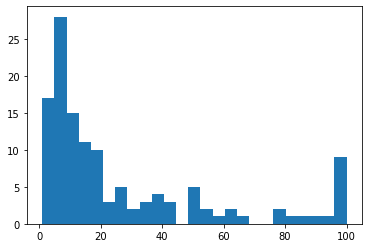

In [30]:
Madrid_venues_count = Madrid_venues.groupby('Neighborhood').count().reset_index()
Madrid_venues_count = Madrid_venues_count[['Neighborhood', 'Venue Category']]
Madrid_venues_count.columns = ['Neighborhood', 'Venue Category Count']

plt.hist(Madrid_venues_count['Venue Category Count'], bins = 25)
plt.show()

In [31]:
#create list with neighborhoods to exclude
neigh_to_exclude = Madrid_venues_count[Madrid_venues_count['Venue Category Count'] < 4]
#create filtered dataframe by excluding neighborhoods in above list
Madrid_venues_filt = Madrid_venues[~Madrid_venues['Neighborhood'].isin(neigh_to_exclude)]
#rename filtered dataframe back to toronto_venues
Madrid_venues = Madrid_venues_filt
#check counts after filtering
Madrid_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Abrantes,7,7,7,7,7,7
Acacias,54,54,54,54,54,54
Adelfas,50,50,50,50,50,50
Alameda de Osuna,23,23,23,23,23,23
Almagro,100,100,100,100,100,100
...,...,...,...,...,...,...
Ventas,11,11,11,11,11,11
"Villaverde Alto, C.H. Villaverde",4,4,4,4,4,4
Vinateros,8,8,8,8,8,8


# 3. Analyze Each Neighborhood

We will do one hot encoding to pivot category values into columns of the dataframe.



In [32]:
# one hot encoding
Madrid_onehot = pd.get_dummies(Madrid_venues[['Venue Category']], prefix="", prefix_sep="")

#rename the column 'Neighborhood' which represents a category name to 'Neighborhood Category' 
#this is to distinguish this column from the 'Neighborhood' column which we want to continue to use as the neighborhood name
Madrid_onehot.rename(columns={'Neighborhood':'Neighborhood Category'}, inplace=True)

# add neighborhood column back to dataframe
Madrid_onehot['Neighborhood'] = Madrid_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Madrid_onehot.columns[-1]] + list(Madrid_onehot.columns[:-1])
Madrid_onehot = Madrid_onehot[fixed_columns]

#Madrid_onehot.head()

In [33]:
Madrid_onehot.shape

(3407, 264)

** We will group rows by neighborhood and by taking the mean of the frequency of occurrence of each category **

In [34]:
Madrid_grouped = Madrid_onehot.groupby('Neighborhood').mean().reset_index()
Madrid_grouped.head(10)

,Neighborhood,Accessories Store,Adult Boutique,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,...,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio,Zoo
0,Abrantes,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
1,Acacias,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2,Adelfas,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
3,Alameda de Osuna,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
4,Almagro,0.0,0.0,0.01,0.0,0.0,0.0,0.01,0.01,0.0,...,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0
5,Almenara,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
6,Almendrales,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
7,Aluche,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
8,Amposta,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
9,Apóstol Santiago,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
Madrid_grouped.shape

(127, 264)

** Store the above into a pandas dataframe **

In [36]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False).to_frame().reset_index()
    row_cutoff = row_categories_sorted.head(num_top_venues)
    row_cutoff.columns = ['Venue', 'Appears']
    return_array = row_cutoff['Venue'].where(row_cutoff['Appears'] != 0, other = np.NaN, axis = 0)

    return return_array.values

In [37]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns = columns)
neighborhoods_venues_sorted['Neighborhood'] = Madrid_grouped['Neighborhood']

for ind in np.arange(Madrid_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Madrid_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abrantes,Park,Fast Food Restaurant,Metro Station,Soccer Field,Pizza Place,Gym / Fitness Center,Athletics & Sports,NaN,NaN,NaN
1,Acacias,Spanish Restaurant,Supermarket,Tapas Restaurant,Bar,Pizza Place,Park,Café,Pub,Indie Theater,Gym / Fitness Center
2,Adelfas,Bar,Tapas Restaurant,Spanish Restaurant,Café,Pizza Place,Breakfast Spot,Grocery Store,Bakery,Supermarket,Metro Station
3,Alameda de Osuna,Restaurant,Tapas Restaurant,Smoke Shop,Fried Chicken Joint,Spanish Restaurant,Bar,Bakery,Scenic Lookout,Grocery Store,Bistro
4,Almagro,Restaurant,Spanish Restaurant,Hotel,Japanese Restaurant,Mediterranean Restaurant,Bar,Nightclub,Supermarket,French Restaurant,Tapas Restaurant


In [38]:
neighborhoods_venues_sorted.groupby(['1st Most Common Venue']).size()

1st Most Common Venue
Asian Restaurant            1
Bakery                      2
Bar                        11
Breakfast Spot              1
Brewery                     1
Café                        1
Cheese Shop                 1
Coffee Shop                 1
Department Store            1
Event Space                 1
Exhibit                     1
Fast Food Restaurant        1
Food & Drink Shop           1
Fruit & Vegetable Store     1
Grocery Store               4
Gym / Fitness Center        1
Hotel                       2
Ice Cream Shop              1
Italian Restaurant          1
Market                      2
Metro Station               1
Multiplex                   1
Music Venue                 1
Park                        6
Pizza Place                 5
Plaza                       3
Pool                        1
Pub                         2
Restaurant                 15
Scenic Lookout              1
Seafood Restaurant          1
Snack Place                 1
Soccer Field      

# 4. Cluster Neighborhoods


In [39]:
# set number of clusters
kclusters = 5

Madrid_grouped_clustering = Madrid_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Madrid_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 3, 3, 3, 3, 0, 5, 3, 0, 0, 3, 0, 3, 3, 5, 3, 3, 3, 3, 0, 5, 5,
       3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3,
       5, 3, 5, 0, 3, 0, 3, 4, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 5, 4, 3, 3,
       0, 0, 5, 0, 4, 0, 0, 3, 3, 3, 0, 3, 0, 0, 3, 3, 3, 4, 0, 3, 0, 3,
       4, 5, 2, 0, 0, 3, 4, 4, 0, 3, 3, 4, 3, 3, 0, 3, 0, 0, 3, 3, 3, 3,
       3, 5, 3, 3, 3, 3, 3, 3, 0, 5, 3, 4, 0, 3, 3, 0, 5])

In [40]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Madrid_merged = neighborhoods_venues_sorted

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Madrid_merged = Madrid_merged.join(Info_barrios.set_index('Neighborhood'), on='Neighborhood')

Madrid_merged.head() # check the last columns!

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Renta,Latitude,Longitude,Colegios
0,0,Abrantes,Park,Fast Food Restaurant,Metro Station,Soccer Field,Pizza Place,Gym / Fitness Center,Athletics & Sports,NaN,NaN,NaN,10544.0,40.37980,-3.72636,4
1,3,Acacias,Spanish Restaurant,Supermarket,Tapas Restaurant,Bar,Pizza Place,Park,Café,Pub,Indie Theater,Gym / Fitness Center,19323.0,40.40137,-3.70669,1
2,3,Adelfas,Bar,Tapas Restaurant,Spanish Restaurant,Café,Pizza Place,Breakfast Spot,Grocery Store,Bakery,Supermarket,Metro Station,18991.0,40.40173,-3.67288,1
3,3,Alameda de Osuna,Restaurant,Tapas Restaurant,Smoke Shop,Fried Chicken Joint,Spanish Restaurant,Bar,Bakery,Scenic Lookout,Grocery Store,Bistro,19871.0,40.45818,-3.58953,1
4,3,Almagro,Restaurant,Spanish Restaurant,Hotel,Japanese Restaurant,Mediterranean Restaurant,Bar,Nightclub,Supermarket,French Restaurant,Tapas Restaurant,26752.0,40.43296,-3.69153,0


In [61]:
# create map of Toronto Neighbourhoods (FSAs) using retrived latitude and longitude values
madrid_pop = folium.Map(location=[40.40833, -3.71865], zoom_start=10)
barrios_madrid_geo = "B:/Formacion/Cursos/Coursera/Data Analist/Data Science by IBM/9. Applied Data Science Capstone/Notebooks/Barrios_madrid.geojson"


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Madrid_merged['Latitude'], Madrid_merged['Longitude'], Madrid_merged['Neighborhood'], Madrid_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(madrid_pop)


madrid_pop

Note: because GitHub doesn't display Folium maps, a print screen of the map is available [here](https://github.com/CasteSan/Coursera_Capstone/blob/main/Battle_Neighborhoods_week2/img/Clusters.png).

# 5. Examine Clusters

In [42]:
def total_venue_categories(df):
    df_all_venues = df['1st Most Common Venue']
    df_all_venues = df_all_venues.append(df['2nd Most Common Venue'])
    df_all_venues = df_all_venues.append(df['3rd Most Common Venue'])
    df_all_venues = df_all_venues.append(df['4th Most Common Venue'])
    df_all_venues = df_all_venues.append(df['5th Most Common Venue'])
    df_all_venues = df_all_venues.append(df['6th Most Common Venue'])
    df_all_venues = df_all_venues.append(df['7th Most Common Venue'])
    df_all_venues = df_all_venues.append(df['8th Most Common Venue'])
    df_all_venues = df_all_venues.append(df['9th Most Common Venue'])
    df_all_venues = df_all_venues.append(df['10th Most Common Venue'])
    df_cnt = df_all_venues.value_counts().to_frame().reset_index()
    df_cnt.columns = ['Venue Category', 'Venue Count']
    df_cnt.sort_values(by = 'Venue Count', ascending = False)
#return the top 10 venue categories
    return df_cnt.head(10)

## Cluster 0: Residential

In [43]:
Madrid_cluster0 = Madrid_merged.loc[Madrid_merged['Cluster Labels'] == 0, Madrid_merged.columns[[1] + list(range(2, Madrid_merged.shape[1]))]]
Madrid_cluster0

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Renta,Latitude,Longitude,Colegios
0,Abrantes,Park,Fast Food Restaurant,Metro Station,Soccer Field,Pizza Place,Gym / Fitness Center,Athletics & Sports,NaN,NaN,NaN,10544.0,40.37980,-3.72636,4
5,Almenara,Gym / Fitness Center,Library,Flea Market,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12877.0,40.47114,-3.69581,2
8,Amposta,Park,Metro Station,Snack Place,Grocery Store,Shopping Mall,Music Venue,Food,NaN,NaN,NaN,8987.0,40.42643,-3.62131,0
9,Apóstol Santiago,Grocery Store,Food Truck,Park,Metro Station,Bakery,NaN,NaN,NaN,NaN,NaN,14396.0,40.47557,-3.66071,0
11,Aravaca,Grocery Store,Pizza Place,Smoke Shop,Diner,Spanish Restaurant,Italian Restaurant,NaN,NaN,NaN,NaN,24362.0,40.45620,-3.78042,2
19,Butarque,Department Store,Food & Drink Shop,Park,Fast Food Restaurant,Athletics & Sports,Supermarket,Pet Store,Diner,Indian Restaurant,NaN,10698.0,40.33935,-3.76848,3
25,Casco Histórico de Vallecas,Scenic Lookout,Bakery,Gym / Fitness Center,Pizza Place,NaN,NaN,NaN,NaN,NaN,NaN,9346.0,40.36251,-3.61710,6
47,Entrevías,Train Station,Pizza Place,Gym / Fitness Center,Restaurant,Park,NaN,NaN,NaN,NaN,NaN,8567.0,40.37925,-3.67212,0
49,Fontarrón,Bar,Plaza,Pub,Ice Cream Shop,Pizza Place,Concert Hall,Food & Drink Shop,Brewery,Fried Chicken Joint,Supermarket,11607.0,40.40301,-3.64910,0
66,Los Cármenes,Fruit & Vegetable Store,Restaurant,Grocery Store,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11469.0,40.40280,-3.73178,0


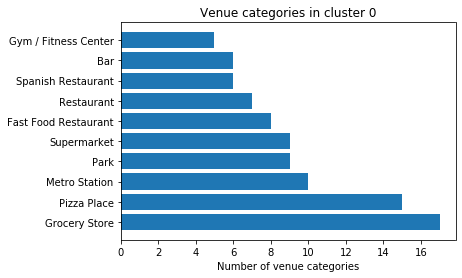

In [72]:
#count venue categories in all neighborhoods in the cluster
t0 = total_venue_categories(Madrid_merged[Madrid_merged['Cluster Labels'] == 0])

y_pos = np.arange(len(t0['Venue Category']))
plt.barh(y_pos, t0['Venue Count'], align='center')
plt.yticks(y_pos, t0['Venue Category'])
plt.xlabel('Number of venue categories')
plt.title('Venue categories in cluster 0')
 
plt.show()

The amount of Grocery Stores, Metro stations, parks and supermarkets indicates that it are probably mainly residential areas.

## Cluster 1: Shopping centre

In [45]:
Madrid_cluster1 = Madrid_merged.loc[Madrid_merged['Cluster Labels'] == 1, Madrid_merged.columns[[1] + list(range(2, Madrid_merged.shape[1]))]]
Madrid_cluster1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Renta,Latitude,Longitude,Colegios
41,El Cañaveral,Market,Clothing Store,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13434.0,40.40728,-3.56454,0


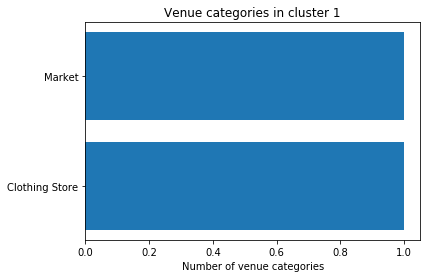

In [71]:
#count venue categories in all neighborhoods in the cluster
t1 = total_venue_categories(Madrid_merged[Madrid_merged['Cluster Labels'] == 1])

y_pos = np.arange(len(t1['Venue Category']))
plt.barh(y_pos, t1['Venue Count'], align='center')
plt.yticks(y_pos, t1['Venue Category'])
plt.xlabel('Number of venue categories')
plt.title('Venue categories in cluster 1')
 
plt.show()

This is just a neighborhood where there must be a shopping centre

## Cluster 2: Downtown

In [49]:
Madrid_cluster2 = Madrid_merged.loc[Madrid_merged['Cluster Labels'] == 3, Madrid_merged.columns[[1] + list(range(2, Madrid_merged.shape[1]))]]
Madrid_cluster2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Renta,Latitude,Longitude,Colegios
1,Acacias,Spanish Restaurant,Supermarket,Tapas Restaurant,Bar,Pizza Place,Park,Café,Pub,Indie Theater,Gym / Fitness Center,19323.0,40.40137,-3.70669,1
2,Adelfas,Bar,Tapas Restaurant,Spanish Restaurant,Café,Pizza Place,Breakfast Spot,Grocery Store,Bakery,Supermarket,Metro Station,18991.0,40.40173,-3.67288,1
3,Alameda de Osuna,Restaurant,Tapas Restaurant,Smoke Shop,Fried Chicken Joint,Spanish Restaurant,Bar,Bakery,Scenic Lookout,Grocery Store,Bistro,19871.0,40.45818,-3.58953,1
4,Almagro,Restaurant,Spanish Restaurant,Hotel,Japanese Restaurant,Mediterranean Restaurant,Bar,Nightclub,Supermarket,French Restaurant,Tapas Restaurant,26752.0,40.43296,-3.69153,0
7,Aluche,Ice Cream Shop,Gym / Fitness Center,Spanish Restaurant,Shopping Mall,Fast Food Restaurant,Tapas Restaurant,Park,Brewery,Pool,Italian Restaurant,12689.0,40.39271,-3.76032,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,Valdefuentes,Pizza Place,Mediterranean Restaurant,Coffee Shop,Bar,Pie Shop,Breakfast Spot,Tapas Restaurant,Middle Eastern Restaurant,Café,Bakery,19838.0,40.49405,-3.65930,4
117,Valdemarín,Tennis Court,Arcade,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30009.0,40.46996,-3.77641,0
120,Vallehermoso,Spanish Restaurant,Restaurant,Bar,Tapas Restaurant,Sandwich Place,Gym / Fitness Center,Coffee Shop,German Restaurant,Gourmet Shop,Grocery Store,24669.0,40.44480,-3.71483,2
123,"Villaverde Alto, C.H. Villaverde",Coffee Shop,Farmers Market,Train,Flea Market,NaN,NaN,NaN,NaN,NaN,NaN,9354.0,40.34922,-3.71211,0


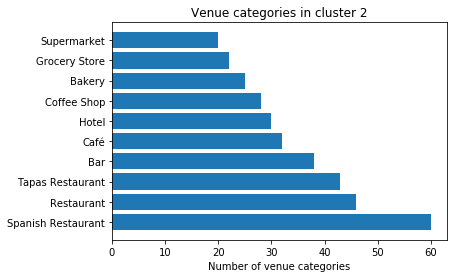

In [70]:
#count venue categories in all neighborhoods in the cluster
t2 = total_venue_categories(Madrid_merged[Madrid_merged['Cluster Labels'] == 3])

y_pos = np.arange(len(t2['Venue Category']))
plt.barh(y_pos, t2['Venue Count'], align='center')
plt.yticks(y_pos, t2['Venue Category'])
plt.xlabel('Number of venue categories')
plt.title('Venue categories in cluster 2')
 
plt.show()

This cluster has mostly high end restaurants and hotels with a couple of coffe shop which suggests it is made up of downtown neighborhoods.

## Cluster 3: New residential neighborhoods

In [51]:
Madrid_cluster3 = Madrid_merged.loc[Madrid_merged['Cluster Labels'] == 4, Madrid_merged.columns[[1] + list(range(2, Madrid_merged.shape[1]))]]
Madrid_cluster3

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Renta,Latitude,Longitude,Colegios
51,Fuentelarreina,Bakery,Soccer Field,Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28731.0,40.48020,-3.73934,0
63,Las Águilas,Bar,Tapas Restaurant,Pizza Place,Park,Sports Club,Café,Athletics & Sports,Train Station,NaN,NaN,12402.0,40.38166,-3.77188,0
70,Marroquina,Park,Bakery,Soccer Field,Nightclub,Tapas Restaurant,NaN,NaN,NaN,NaN,NaN,16232.0,40.41176,-3.64618,2
83,Palomeras Bajas,Park,Concert Hall,Gym,Tapas Restaurant,Supermarket,Soccer Stadium,NaN,NaN,NaN,NaN,11148.0,40.38756,-3.66029,5
88,Pilar,Park,Bakery,Tapas Restaurant,Supermarket,Kebab Restaurant,Pizza Place,American Restaurant,Italian Restaurant,Flea Market,Comic Shop,14477.0,40.47543,-3.71130,0
94,Pueblo Nuevo,Bar,Tapas Restaurant,Gym,Brewery,NaN,NaN,NaN,NaN,NaN,NaN,12033.0,40.42895,-3.63826,2
95,Puerta Bonita,Bar,Bakery,Pizza Place,Rest Area,Park,NaN,NaN,NaN,NaN,NaN,9712.0,40.37982,-3.74046,2
99,Rosas,Tapas Restaurant,Restaurant,Gym,Park,Grocery Store,Seafood Restaurant,Metro Station,Soccer Field,Brewery,NaN,15723.0,40.42869,-3.60086,3
121,Valverde,Train Station,Spanish Restaurant,Food,Tapas Restaurant,Park,NaN,NaN,NaN,NaN,NaN,16091.0,40.49991,-3.68608,6


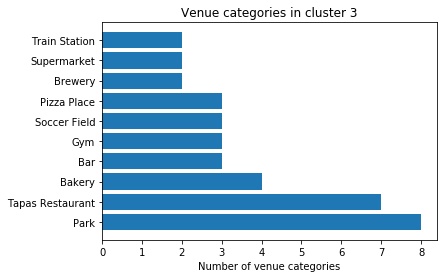

In [69]:
#count venue categories in all neighborhoods in the cluster
t3 = total_venue_categories(Madrid_merged[Madrid_merged['Cluster Labels'] == 4])

y_pos = np.arange(len(t3['Venue Category']))
plt.barh(y_pos, t3['Venue Count'], align='center')
plt.yticks(y_pos, t3['Venue Category'])
plt.xlabel('Number of venue categories')
plt.title('Venue categories in cluster 3')

plt.show()

Similar to the first residential neighborhoods where there are a lot of parks and supermarket but also gym and even soccer fields suggesting a newer residential neighborhood

## Cluster 4: Food lovers residential neighborhoods

In [53]:
Madrid_cluster4 = Madrid_merged.loc[Madrid_merged['Cluster Labels'] == 5, Madrid_merged.columns[[1] + list(range(2, Madrid_merged.shape[1]))]]
Madrid_cluster4

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Renta,Latitude,Longitude,Colegios
6,Almendrales,Spanish Restaurant,Seafood Restaurant,Restaurant,Gastropub,Nightclub,Pub,Noodle House,Chinese Restaurant,Grocery Store,Bakery,9589.0,40.38431,-3.69992,1
14,Atalaya,Spanish Restaurant,Restaurant,Asian Restaurant,Chinese Restaurant,American Restaurant,Bus Station,Nightclub,Bakery,Flower Shop,NaN,25974.0,40.46457,-3.66335,0
20,Campamento,Spanish Restaurant,Diner,Light Rail Station,Bus Station,NaN,NaN,NaN,NaN,NaN,NaN,12519.0,40.39666,-3.77408,3
21,Canillas,Spanish Restaurant,Juice Bar,Pizza Place,Irish Pub,Argentinian Restaurant,Soccer Field,Pet Store,Comic Shop,Miscellaneous Shop,Bar,16175.0,40.46448,-3.64338,4
44,El Viso,Spanish Restaurant,Pizza Place,Bakery,Plaza,Restaurant,Coffee Shop,Sandwich Place,Café,Bistro,Sushi Restaurant,28945.0,40.44746,-3.68543,3
46,Ensanche de Vallecas,Park,Pizza Place,Soccer Field,Spanish Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,13831.0,40.37896,-3.61384,1
57,Horcajo,Spanish Restaurant,Soccer Stadium,Pizza Place,Park,Bakery,Tapas Restaurant,Gym / Fitness Center,NaN,NaN,NaN,15736.0,40.40729,-3.62737,0
62,La Paz,Spanish Restaurant,Food & Drink Shop,College Gym,Athletics & Sports,Restaurant,Park,NaN,NaN,NaN,NaN,22078.0,40.48158,-3.69427,5
68,Los Ángeles,Spanish Restaurant,Pet Store,Café,Basketball Court,Restaurant,Bar,NaN,NaN,NaN,NaN,11245.0,40.35641,-3.69598,0
89,Pinar del Rey,Spanish Restaurant,Plaza,Supermarket,Restaurant,Mediterranean Restaurant,Bakery,Soccer Field,Pizza Place,Pharmacy,Pub,13932.0,40.47225,-3.64943,6


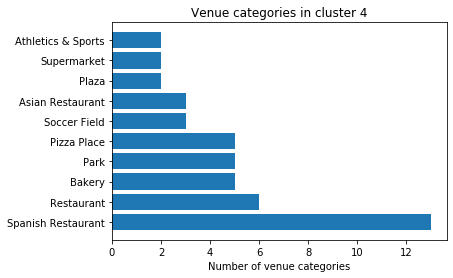

In [68]:
#count venue categories in all neighborhoods in the cluster
t4 = total_venue_categories(Madrid_merged[Madrid_merged['Cluster Labels'] == 5])

y_pos = np.arange(len(t4['Venue Category']))
plt.barh(y_pos, t4['Venue Count'], align='center')
plt.yticks(y_pos, t4['Venue Category'])
plt.xlabel('Number of venue categories')
plt.title('Venue categories in cluster 4')
 
plt.show()

Pretty similar to the cluster 3 with tipical residential services like supermarkets, parks but with a higher amount of restaurants

## Comparing to public schools distribution

In [60]:
# create map of Toronto Neighbourhoods (FSAs) using retrived latitude and longitude values
madrid_pop = folium.Map(location=[40.40833, -3.71865], zoom_start=10)
barrios_madrid_geo = "B:/Formacion/Cursos/Coursera/Data Analist/Data Science by IBM/9. Applied Data Science Capstone/Notebooks/Barrios_madrid.geojson"
madrid_pop.choropleth(geo_data=barrios_madrid_geo,
    data = Info_barrios,
    columns=['Neighborhood','Colegios'],
    key_on='feature.properties.nombre',
    fill_color='YlOrRd',
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Nº colegios publicos por barrio, 2020')   
    

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Madrid_merged['Latitude'], Madrid_merged['Longitude'], Madrid_merged['Neighborhood'], Madrid_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(madrid_pop)


madrid_pop

Note: because GitHub doesn't display Folium maps, a print screen of the map is available [here](https://github.com/CasteSan/Coursera_Capstone/blob/main/Battle_Neighborhoods_week2/img/Clusters_schools.png).